# Data Science pipeline in action to solve employee attrition problem

This code pattern is a high level overview of what to expect in a data science pipeline and tools that can be used along the way. It starts from framing business question to deploying the model. The pipeline is demonstrated through the employee attrition problem. 

Employees are the backbone of the organization. Organization's performance is heavily based on the quality of the employees. Challenges that an organization has to face due employee attrition are:

1. Expensive in terms of both money and time to train new employees.
2. Loss of experienced employees
3. Impact in productivity
4. Impact profit

Before getting our hands dirty with the data, first step is to frame the business question. Having clarity on below questions is very crucial because the solution that is being developed will make sense only if we have well stated problem.

“Good data science is more about the questions you pose of the data rather than data munging and analysis” — Riley Newman

### Business questions to brainstorm:

1. What factors are contributing more to employee attrition?
2. What type of measures should the company take in order to retain their employees?
3. What business value does the model bring?
4. Will the model save lots of money?
5. Which business unit faces the attrition problem?


### Data Science Process Pipeline 

<img src="https://github.com/IBM/employee-attrition-aif360/raw/master/doc/source/images/pipeline.png" width="800" />

Above image explains the steps involved in solving a data science problem. It starts from data extraction to result interpretation. Once the model produces acceptable performance, it can be deployed in real-time. 

### Let's solve employee attrition problem...

In [1]:
!pip install pygal

     |████████████████████████████████| 133kB 15.5MB/s eta 0:00:01


In [2]:
!pip install cufflinks

     |████████████████████████████████| 81kB 16.4MB/s eta 0:00:01
     |████████████████████████████████| 7.2MB 16.8MB/s eta 0:00:01
     |████████████████████████████████| 81kB 28.5MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/44/d7/dc/e830ab00bc2dd3b2731295103baa070f8cbdda8891f71a7a8d
Successfully built cufflinks
  Found existing installation: plotly 3.6.1
    Uninstalling plotly-3.6.1:
      Successfully uninstalled plotly-3.6.1


In [3]:
!pip install aif360

     |████████████████████████████████| 56.4MB 56.2MB/s eta 0:00:01
     |████████████████████████████████| 20.0MB 40.5MB/s eta 0:00:01
ERROR: tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.
ERROR: autoai-libs 1.10.3 has requirement pandas>=0.24.2, but you'll have pandas 0.24.1 which is incompatible.
  Found existing installation: numpy 1.15.4
    Uninstalling numpy-1.15.4:
      Successfully uninstalled numpy-1.15.4


In [5]:
#import all required libraries
#Data Analysis
import pandas as pd
import numpy as np
import json

#Visulaization libraries
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.palettes import Viridis5
import seaborn as sns
import matplotlib.pyplot as plt
import pygal
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

#model developemnt libraries
from sklearn import preprocessing
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#Bias Mitigation libraries
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset
from IPython.display import Markdown, display
from aif360.algorithms.preprocessing.reweighing import Reweighing

#
from IPython.display import SVG, display
import warnings
warnings.filterwarnings("ignore")
#deployment library
from watson_machine_learning_client import WatsonMachineLearningAPIClient

## 1.  Data Collection

- Source: Kaggle
- Data: IBM HR Analytics dataset (synthetically generated)
  https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset/home
- License: 
    *  Database: https://opendatacommons.org/licenses/odbl/1.0/
    *  Contents: https://opendatacommons.org/licenses/dbcl/1.0/

#### Rule of thumb
* Know all the available dataset for the problem (database/ internet/ third party etc) . Dataset must be reliable and   authentic.
* Extract data in a format that can be used
* Required Skills for data extraction in general(mostly used and not specific to the pattern):
   - Distributed Storage: Hadoop, Apache Spark.
   - Database Management: MySQL, PostgresSQL, MongoDB.
   - Know to querying Relational Databases and retrieve unstructured Data like text, videos, audio files, documents.

#### Download dataset 

In [6]:
!wget https://github.com/IBM/employee-attrition-aif360/raw/master/data/emp_attrition.csv --output-document=emp_attrition.csv

--2019-11-11 04:50:40--  https://github.com/IBM/employee-attrition-aif360/raw/master/data/emp_attrition.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/employee-attrition-aif360/master/data/emp_attrition.csv [following]
--2019-11-11 04:50:41--  https://raw.githubusercontent.com/IBM/employee-attrition-aif360/master/data/emp_attrition.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 227977 (223K) [text/plain]
Saving to: ‘emp_attrition.csv’

100%[======================================>] 227,977     --.-K/s   in 0.02s   

2019-11-11 04:50:41 (11.9 MB/s) - ‘emp_attrition.csv’ saved [227977/227977]



In [7]:
#Reading csv file in pandas dataframe format. 
df_data = pd.read_csv('emp_attrition.csv')
df_data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [8]:
#Get list of columns in the dataset
df_data.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [9]:
#Dropping columns (intution)
columns = ['DailyRate', 'EducationField', 'EmployeeCount', 'EmployeeNumber', 'HourlyRate', 'MonthlyRate',
        'Over18', 'RelationshipSatisfaction', 'StandardHours']
df_data.drop(columns, inplace=True, axis=1)

### 1.1 Get description of data

Generates descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.

Reference link: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.describe.html

In [10]:
#This will give description only for numeric fields
df_data.describe()

,Age,DistanceFromHome,Education,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,9.192517,2.912925,2.721769,2.729932,2.063946,2.728571,6502.931293,2.693197,15.209524,3.153741,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,8.106864,1.024165,1.093082,0.711561,1.106940,1.102846,4707.956783,2.498009,3.659938,0.360824,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1009.000000,0.000000,11.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2911.000000,1.000000,12.000000,3.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,7.000000,3.000000,3.000000,3.000000,2.000000,3.000000,4919.000000,2.000000,14.000000,3.000000,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,14.000000,4.000000,4.000000,3.000000,3.000000,4.000000,8379.000000,4.000000,18.000000,3.000000,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,29.000000,5.000000,4.000000,4.000000,5.000000,4.000000,19999.000000,9.000000,25.000000,4.000000,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [11]:
#To get description of all columns
df_data.describe(include = 'all')

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,...,PercentSalaryHike,PerformanceRating,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470,1470,1470,1470.000000,1470.000000,1470.000000,1470,1470.000000,1470.000000,...,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
unique,NaN,2,3,3,NaN,NaN,NaN,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,No,Travel_Rarely,Research & Development,NaN,NaN,NaN,Male,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1233,1043,961,NaN,NaN,NaN,882,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,36.923810,NaN,NaN,NaN,9.192517,2.912925,2.721769,NaN,2.729932,2.063946,...,15.209524,3.153741,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,NaN,NaN,NaN,8.106864,1.024165,1.093082,NaN,0.711561,1.106940,...,3.659938,0.360824,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,NaN,NaN,NaN,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,...,11.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,NaN,NaN,NaN,2.000000,2.000000,2.000000,NaN,2.000000,1.000000,...,12.000000,3.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,NaN,NaN,NaN,7.000000,3.000000,3.000000,NaN,3.000000,2.000000,...,14.000000,3.000000,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,NaN,NaN,NaN,14.000000,4.000000,4.000000,NaN,3.000000,3.000000,...,18.000000,3.000000,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000


## 2. Data Cleaning

This phase is the most time consuming yet the most importat one. Here, we filter and extract only the information that is needed for problem solving. Quality of the model is highly dependant on the quality of the data that is given as an input. 
* Understand meaning of every feature and identify errors.
* Look for any missing values and find a way to fill the missing values.
* Remove duplicate or corrupted records.
* Scaling and normalization of data.
* Character encoding (string to numerical representation).
* Handle inconsistent entry.
* Use tools like pandas(python), dplyr(R), numpy.

### 2.1 Handling missing values

In [12]:
#Find number of missing values in every feature
df_data.isnull().sum()

Age                        0
Attrition                  0
BusinessTravel             0
Department                 0
DistanceFromHome           0
Education                  0
EnvironmentSatisfaction    0
Gender                     0
JobInvolvement             0
JobLevel                   0
JobRole                    0
JobSatisfaction            0
MaritalStatus              0
MonthlyIncome              0
NumCompaniesWorked         0
OverTime                   0
PercentSalaryHike          0
PerformanceRating          0
StockOptionLevel           0
TotalWorkingYears          0
TrainingTimesLastYear      0
WorkLifeBalance            0
YearsAtCompany             0
YearsInCurrentRole         0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
dtype: int64

Looks like the best dataset!!! No null values :-)

#### But what if we have null values ???? Let's see what we can do in that case.

* Find why that data is missing. Human error or missed during extraction
* Drop missing values. 
* Some ways for filling missing values: 
  - Zero 
  - Mean ( works with normal distribution )
  - Random values from same distribution ( works well with equal distribution ) 
  - Value after missing value (make sense if data set has some logical order)

### 2.2 Encode categorical features(in string) as most of the tools works with numbers

In [13]:
#Columns with string values
categorical_column = ['Attrition', 'BusinessTravel', 'Department',
                      'Gender', 'JobRole', 'MaritalStatus', 'OverTime']

In [14]:
#Deep copy the original data
data_encoded = df_data.copy(deep=True)
#Use Scikit-learn label encoding to encode character data
lab_enc = preprocessing.LabelEncoder()
for col in categorical_column:
        data_encoded[col] = lab_enc.fit_transform(df_data[col])
        le_name_mapping = dict(zip(lab_enc.classes_, lab_enc.transform(lab_enc.classes_)))
        print('Feature', col)
        print('mapping', le_name_mapping)

Feature Attrition
mapping {'No': 0, 'Yes': 1}
Feature BusinessTravel
mapping {'Non-Travel': 0, 'Travel_Frequently': 1, 'Travel_Rarely': 2}
Feature Department
mapping {'Human Resources': 0, 'Research & Development': 1, 'Sales': 2}
Feature Gender
mapping {'Female': 0, 'Male': 1}
Feature JobRole
mapping {'Healthcare Representative': 0, 'Human Resources': 1, 'Laboratory Technician': 2, 'Manager': 3, 'Manufacturing Director': 4, 'Research Director': 5, 'Research Scientist': 6, 'Sales Executive': 7, 'Sales Representative': 8}
Feature MaritalStatus
mapping {'Divorced': 0, 'Married': 1, 'Single': 2}
Feature OverTime
mapping {'No': 0, 'Yes': 1}


In [15]:
data_encoded.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,...,PercentSalaryHike,PerformanceRating,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,2,2,1,2,2,0,3,2,...,11,3,0,8,0,1,6,4,0,5
1,49,0,1,1,8,1,3,1,2,2,...,23,4,1,10,3,3,10,7,1,7
2,37,1,2,1,2,2,4,1,2,1,...,15,3,0,7,3,3,0,0,0,0
3,33,0,1,1,3,4,4,0,3,1,...,11,3,0,8,3,3,8,7,3,0
4,27,0,2,1,2,1,1,1,3,1,...,12,3,1,6,3,3,2,2,2,2


## 3. Data Exploration

* Find patterns in data through data visualization. Reveal hidden secrets of the data through graphs, analysis and charts.
   -  Univariate analysis 
      * Continous variables : Histograms, boxplots. This gives us understanding about the central tendency and spread
      * Categorical variable : Bar chart showing frequency in each category 
   -  Bivariate analysis
      * Continous & Continous : Scatter plots to know how continous variables interact with each other
      * Categorical & categorical : Stacked column chart to show how the frequencies are spread between two  
        categorical variables
      * Categorical & Continous : Boxplots, Swamplots or even bar charts
* Detect outliers
* Feature engineering 

### 3.1 Get data distribution between output classes

In [16]:
data_encoded['Attrition'].value_counts()

0    1233
1     237
Name: Attrition, dtype: int64

From the above result, we can find that about 82% of people stick to the company while rest of them quit :-(


**** Data is unbalanced ****

### 3.2 Finding correlation between variables

In [17]:
data_correlation = data_encoded.corr()

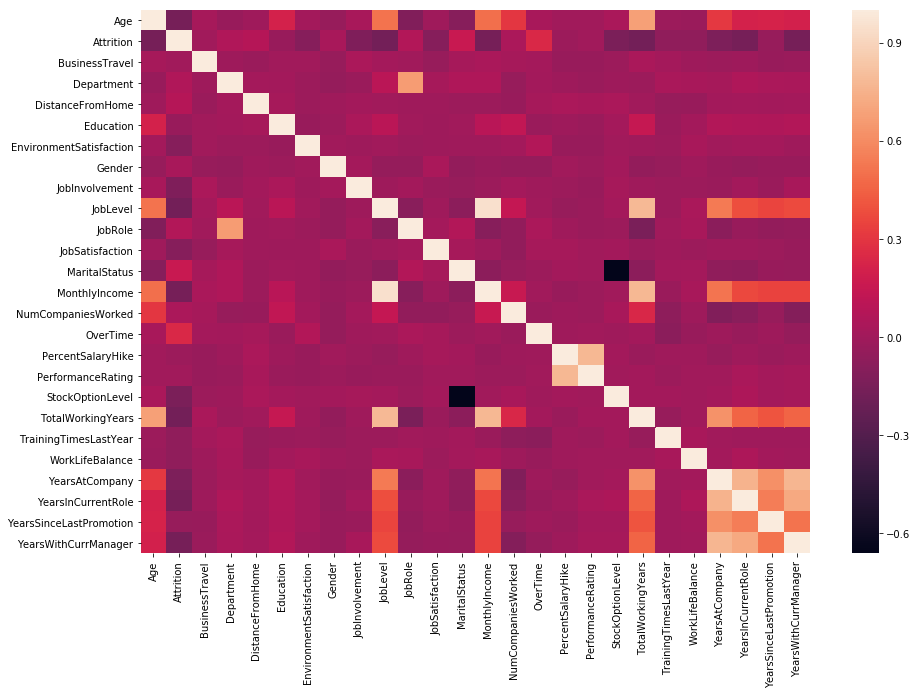

In [18]:
plt.rcParams["figure.figsize"] = [15,10]
sns.heatmap(data_correlation,xticklabels=data_correlation.columns,yticklabels=data_correlation.columns)

#### Analysis of correlation results (sample analysis)

- Monthly income is highly correlated with Job level.
- Job level is highly correlated with total working hours.
- Monthly income is highly correlated with total working hours.
- Age is also positively correlated with the Total working hours.
- Marital status and stock option level are negatively correlated

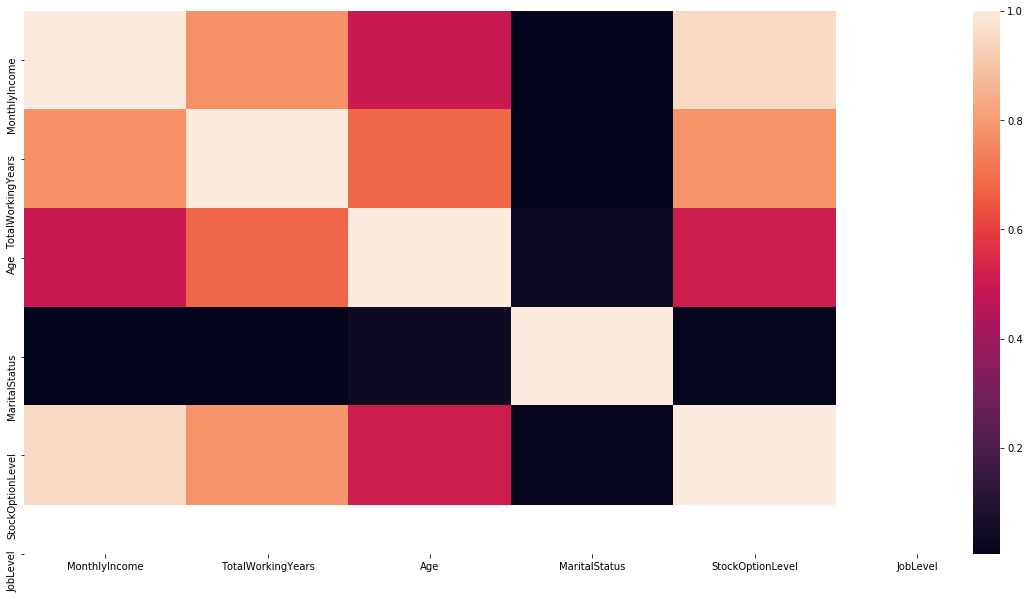

In [19]:
#Viewing the analysis obtained above 
data_corr_filtered = df_data[['MonthlyIncome', 'TotalWorkingYears', 'Age', 'MaritalStatus', 'StockOptionLevel',
                      'JobLevel']]
correlation = data_corr_filtered.corr()
plt.rcParams["figure.figsize"] = [20,10]
sns.heatmap(correlation,xticklabels=data_corr_filtered.columns,yticklabels=data_corr_filtered.columns)

### 3.3 Understanding relationship between features and finding patterns in data through visualization

Popular data visualization libraries in python are:
     1. Matplotlib
     2. Seaborn
     3. ggplot
     4. Bokeh
     5. pygal
     6. Plotly
     7. geoplotlib
     8. Gleam
     9. missingno
     10. Leather

### 3.3.1 Age Analysis
Finding relationship between age and attrition. 

(array([  0.,  17., 309., 622., 349., 168.,   5.]),
 array([ 0, 10, 20, 30, 40, 50, 60, 70]),
 <a list of 7 Patch objects>)

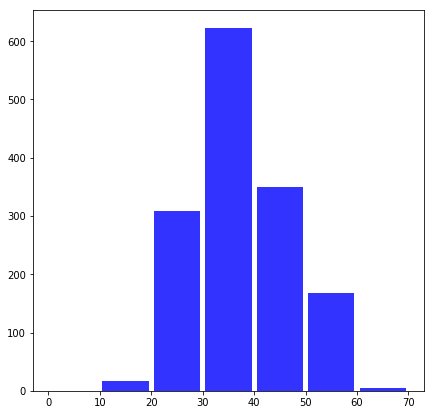

In [20]:
#Plot to see distribution of age overall
plt.rcParams["figure.figsize"] = [7,7]
plt.hist(data_encoded['Age'], bins=np.arange(0,80,10), alpha=0.8, rwidth=0.9, color='blue')

#### Finding based on above plot
This plot tells that there are more employees in the range of 30 to 40. Approximately 45% of employees fall in this range.

In [21]:
#We are going to bin age (multiples of 10) to see which age group are likely to leave the company.
#Before that, let us take only employee who are likely to quit.
positive_attrition_df = data_encoded.loc[data_encoded['Attrition'] == 1]
negative_attrition_df = data_encoded.loc[data_encoded['Attrition'] == 0]

(array([ 0., 10., 81., 89., 34., 23.,  0.]),
 array([ 0, 10, 20, 30, 40, 50, 60, 70]),
 <a list of 7 Patch objects>)

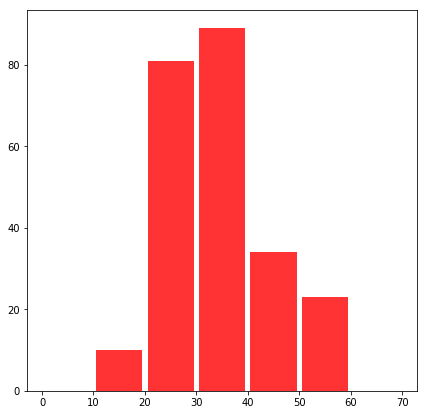

In [22]:
plt.hist(positive_attrition_df['Age'], bins=np.arange(0,80,10), alpha=0.8, rwidth=0.9, color='red')

#### Findings based on above plot
- Employees whose age is in the range of 30 - 40 are more likely to quit.
- Employees in the range of 20 to 30 are also equally imposing the threat to employers.

### 3.3.2 Business Travel vs Attrition
There are 3 categories in this:
    1. No travel (0).
    2. Travel Frequently (1).
    3. Travel Rarely (2).
Attrition: No = 0 and Yes = 1

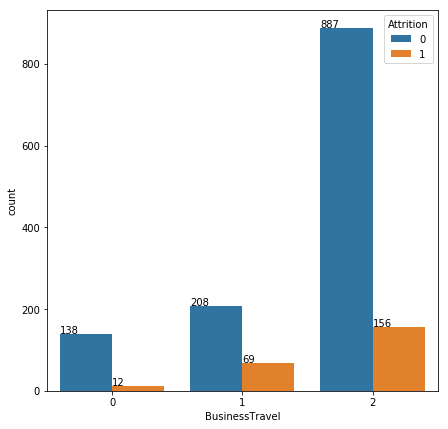

In [23]:
ax = sns.countplot(x="BusinessTravel", hue="Attrition", data=data_encoded)
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x(), p.get_height()+1))

#### Findings
From the above plot it can be inferred that travel can not be a compelling factor for attrition. Employee who travel rarely are likely to quit more

### 3.3.3 Department Vs Attrition
There are three categories in department:
       1. Human Resources: 0
       2. Research & Development: 1
       3. Sales: 2
Attrition: No = 0 and Yes = 1

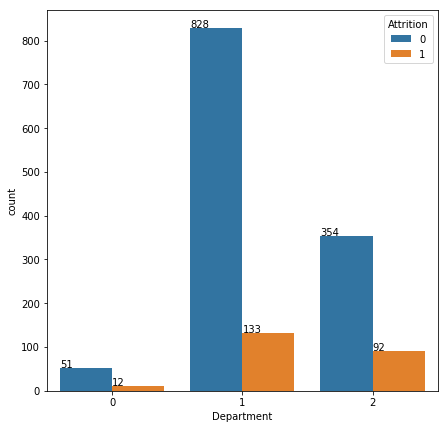

In [24]:
ax = sns.countplot(x="Department", hue="Attrition", data=data_encoded)
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x(), p.get_height()+1))

#### Inference:
    1. 56% of employess from research and development department are likely to quit.
    2. 38% of employees from sales department are likely to quit.

### 3.3.4 Distance from home Vs Employee Attrition

(array([807., 246., 180.,   0.,   0.,   0.,   0.]),
 array([ 0, 10, 20, 30, 40, 50, 60, 70]),
 <a list of 7 Patch objects>)

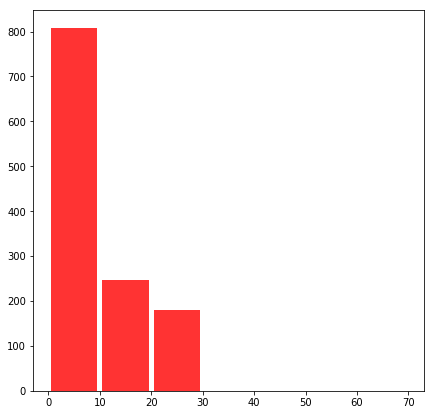

In [25]:
plt.hist(negative_attrition_df['DistanceFromHome'], bins=np.arange(0,80,10), alpha=0.8, rwidth=0.9, color='red')

(array([133.,  55.,  49.,   0.,   0.,   0.,   0.]),
 array([ 0, 10, 20, 30, 40, 50, 60, 70]),
 <a list of 7 Patch objects>)

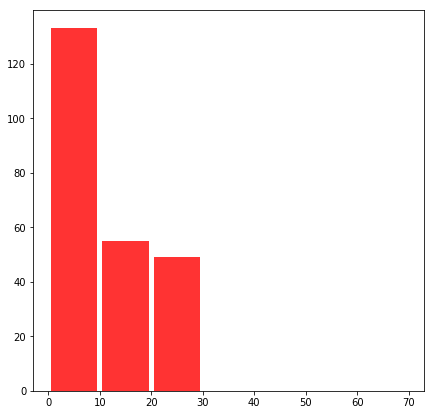

In [26]:
plt.hist(positive_attrition_df['DistanceFromHome'], bins=np.arange(0,80,10), alpha=0.8, rwidth=0.9, color='red')

#### Findings
People who live closeby (0-10 miles) are likely to quit more based on the data

### 3.3.5 Education vs Attrition
There are five categories: 
     1. Below College - 1 
     2. College - 2
     3. Bachelor - 3
     4. Master - 4
     5. Doctor - 5

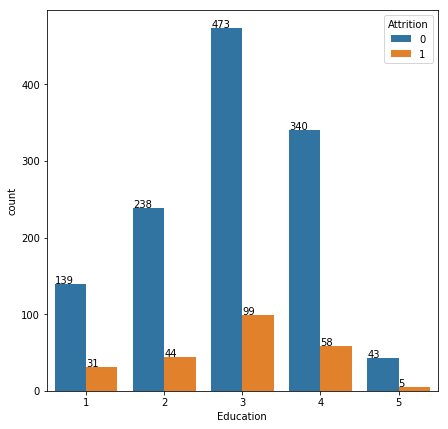

In [27]:
ax = sns.countplot(x="Education", hue="Attrition", data=data_encoded)
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x(), p.get_height()+1))

Inference:
    1. 41% of employees having bachelor's degree are likely to quit.
    2. 24% of employees having master's are the next in line

### 3.3.6 Gender vs Attrition

In [28]:
df_age = data_encoded.copy(deep=True)
df_age.loc[df_age['Age'] <= 20, 'Age'] = 0
df_age.loc[(df_age['Age'] > 20) & (df_age['Age'] <= 30), 'Age'] = 1
df_age.loc[(df_age['Age'] > 30) & (df_age['Age'] <= 40), 'Age'] = 2
df_age.loc[(df_age['Age'] > 40) & (df_age['Age'] <= 50), 'Age'] = 3
df_age.loc[(df_age['Age'] > 50), 'Age'] = 4

In [29]:
df_age = pd.DataFrame({'count': df_age.groupby(["Gender", "Attrition"]).size()}).reset_index()
df_age['Gender-attrition'] = df_age['Gender'].astype(str) + "-" + df_age['Attrition'].astype(str).map(str)

In [30]:
df_age

,Gender,Attrition,count,Gender-attrition
0,0,0,501,0-0
1,0,1,87,0-1
2,1,0,732,1-0
3,1,1,150,1-1


Here,

* Gender - 0 and Attrition - 0 ===> Female employees who will stay
* Gender - 0 and Attrition - 1 ===> Female employees who will leave
* Gender - 1 and Attrition - 0 ===> Male employees who will stay
* Gender - 1 and Attrition - 1 ===> Male employees who will leave

In [31]:
output_notebook() 

# x and y axes
Gender_Attrition = df_age['Gender-attrition'].tolist()
count = df_age['count'].tolist()

print(count)

# Bokeh's mapping of column names and data lists
source = ColumnDataSource(data=dict(Gender_Attrition=Gender_Attrition, count=count, color=Viridis5))

plot_bar = figure(x_range=Gender_Attrition, plot_height=350, title="Counts")

# Render and show the vbar plot
plot_bar.vbar(x='Gender_Attrition', top='count', width=0.9, color='color', source=source)
show(plot_bar)


Loading BokehJS ...

[501, 87, 732, 150]


#### Findings

From the above plot, we can infer that male employees are likely to leave organization as they amount to 63% compared to female who have 36 % attrition rate.

### 3.3.7 Job Role Vs Attrition

Categories in job role:
* Healthcare Representative : 0 
* Human Resources : 1
* Laboratory Technician : 2
* Manager : 3 
* Manufacturing Director : 4
* Research Director : 5
* Research Scientist : 6
* Sales Executive : 7 
* Sales Representative : 8

In [32]:
df_jrole = pd.DataFrame({'count': data_encoded.groupby(["JobRole", "Attrition"]).size()}).reset_index()

In [33]:
#Considering attrition case
df_jrole_1 = df_jrole.loc[df_jrole['Attrition'] == 1]

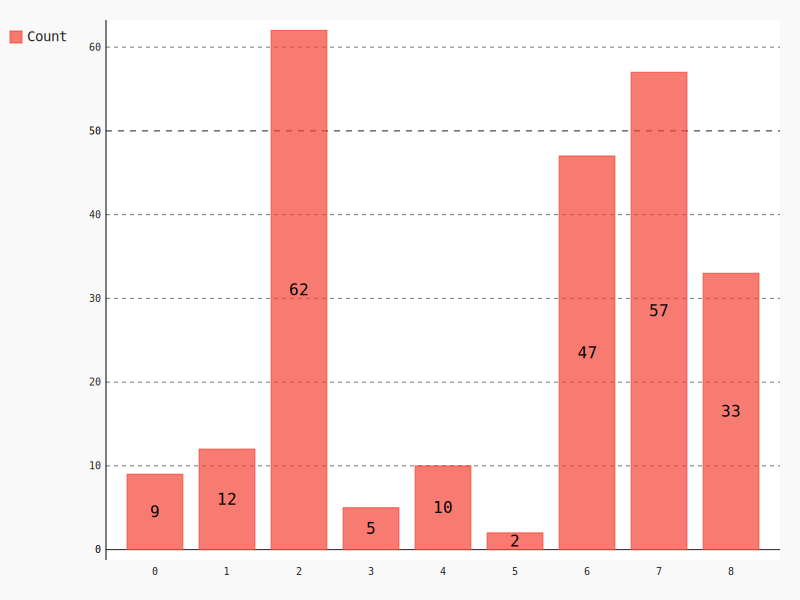

In [34]:
import pygal
chart = pygal.Bar(print_values=True)
chart.x_labels = map(str, range(0,9))
chart.add('Count', df_jrole_1['count'])
#chart.render()
display(SVG(chart.render(disable_xml_declaration=True)))

#### Findings:
Top three roles facing attrition
- 26% of employees who are likely to quit belong to Laboratory Technician group
- 24% of employees belong to Sales Executive group
- 19% of employees belong to Research Scientist group

### 3.3.8 Marital Status vs Attrition

Categories:
    1. 'Divorced': 0
    2. 'Married' : 1
    3. 'Single'  : 2

In [35]:
#analyzing employees who has positive attrition
init_notebook_mode(connected=True)
cf.go_offline()
positive_attrition_df['MaritalStatus'].value_counts().iplot(kind='bar')

#### Inference:
Nearly 50 % of the employees who are single are likely to quit

### 3.3.9 Monthly Income vs Attrition

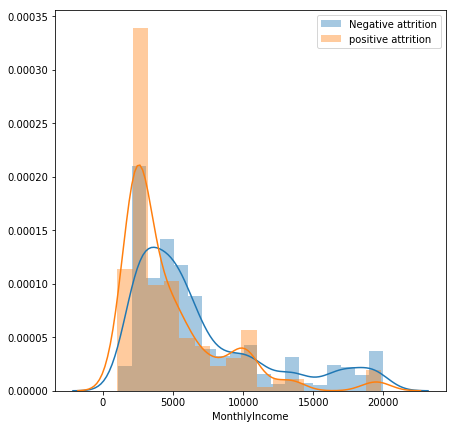

In [36]:
sns.distplot(negative_attrition_df['MonthlyIncome'], label='Negative attrition')
sns.distplot(positive_attrition_df['MonthlyIncome'], label='positive attrition')
plt.legend()

Inference:
    Looks like people who are less likely to leave the company are the ones who are less paid.

## 4. Model Development

## 4.1 Extracting label from input data

In [37]:
input_data = data_encoded.drop(['Attrition'], axis=1)

In [38]:
input_data.head()

,Age,BusinessTravel,Department,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,...,PercentSalaryHike,PerformanceRating,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,2,2,1,2,2,0,3,2,7,...,11,3,0,8,0,1,6,4,0,5
1,49,1,1,8,1,3,1,2,2,6,...,23,4,1,10,3,3,10,7,1,7
2,37,2,1,2,2,4,1,2,1,2,...,15,3,0,7,3,3,0,0,0,0
3,33,1,1,3,4,4,0,3,1,6,...,11,3,0,8,3,3,8,7,3,0
4,27,2,1,2,1,1,1,3,1,2,...,12,3,1,6,3,3,2,2,2,2


In [39]:
target_data = data_encoded[['Attrition']]

In [40]:
target_data.head()

,Attrition
0,1
1,0
2,1
3,0
4,0


In [41]:
len(input_data.columns)

25

## 4.2 Feature Selection

It is the process of choosing the best features that can be used in the predictive modeling. 

1. Fight against the curse of dimensionality.
2. Reduce the overall training time.
3. Defense against overfitting.
4. Increase model generalizability.

Some of the feature selection methods are,
1. Filter methods
   - F Test
   - Mutual information
   - Variance threshold
   - Chi Square
   - Correlation coefficient 
   - ANNOVA
   - LDA
2. Wrapper methods
   - Forward search
   - Backward selection
   - Recursive feature elimination
3. Embedded methods
   - LASSO Linear Regression

In [42]:
input_data.columns

Index(['Age', 'BusinessTravel', 'Department', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel',
       'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [43]:
col_values = list(input_data.columns.values)

#### Mutual Information
It measures the dependence of one variable to another. If,

* Mutual information is 0, then variable X carries no information about the variable Y. X and Y are independent.
* Mutual information is 1, then variable X can be determined from variable Y. X and Y are dependent.

Features can be selected based on their mutual information value.

In [44]:
#gives top 10 features having maximum mutual information value
feature_scores = mutual_info_classif(input_data, target_data)
for score, fname in sorted(zip(feature_scores, col_values), reverse=True)[:10]:
    print(fname, score)

OverTime 0.03246063748660388
MonthlyIncome 0.031111537312169535
JobRole 0.02751330509335359
Age 0.021944603792978024
StockOptionLevel 0.020911708094607295
YearsWithCurrManager 0.020093743804097564
JobLevel 0.019242372429219223
YearsAtCompany 0.0160883475000404
MaritalStatus 0.014207743266430928
JobSatisfaction 0.013316084565630826


#### chi-square

chi-square test is applied to test the independence of two events. This method is used to evaluate the likelihood of correlation or association between features using their frequency distribution. This works best with categorial features.

In [45]:
#gives top 10 features having maximum chi-square value
feature_scores = chi2(input_data, target_data)[0]
for score, fname in sorted(zip(feature_scores, col_values), reverse=True)[:10]:
    print(fname, score)

MonthlyIncome 127922.29369381821
TotalWorkingYears 230.72161773754925
YearsAtCompany 142.10005430324915
YearsInCurrentRole 117.5225958913567
YearsWithCurrManager 110.6715338985734
Age 84.15527681001525
OverTime 63.84506671452294
DistanceFromHome 63.77214163101213
StockOptionLevel 25.26882603175403
JobLevel 24.93924234571862


In [46]:
df_data.shape

(1470, 26)

In [47]:
#column selection based on feature selection 
data_selected = df_data[['MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole', 
                      'YearsWithCurrManager', 'Age', 'OverTime', 'DistanceFromHome', 'StockOptionLevel',
                      'JobLevel', 'JobRole', 'WorkLifeBalance', 'Gender', 'Attrition']]

In [48]:
data_selected.head()

,MonthlyIncome,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole,YearsWithCurrManager,Age,OverTime,DistanceFromHome,StockOptionLevel,JobLevel,JobRole,WorkLifeBalance,Gender,Attrition
0,5993,8,6,4,5,41,Yes,1,0,2,Sales Executive,1,Female,Yes
1,5130,10,10,7,7,49,No,8,1,2,Research Scientist,3,Male,No
2,2090,7,0,0,0,37,Yes,2,0,1,Laboratory Technician,3,Male,Yes
3,2909,8,8,7,0,33,Yes,3,0,1,Research Scientist,3,Female,No
4,3468,6,2,2,2,27,No,2,1,1,Laboratory Technician,3,Male,No


In [49]:
len(data_selected.columns)

14

In [50]:
data_selected.shape

(1470, 14)

In [51]:
#encoding labels
data_selected.loc[data_selected.Attrition == 'No', 'Attrition'] = 0
data_selected.loc[data_selected.Attrition == 'Yes', 'Attrition'] = 1

In [52]:
data_selected.head()

,MonthlyIncome,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole,YearsWithCurrManager,Age,OverTime,DistanceFromHome,StockOptionLevel,JobLevel,JobRole,WorkLifeBalance,Gender,Attrition
0,5993,8,6,4,5,41,Yes,1,0,2,Sales Executive,1,Female,1
1,5130,10,10,7,7,49,No,8,1,2,Research Scientist,3,Male,0
2,2090,7,0,0,0,37,Yes,2,0,1,Laboratory Technician,3,Male,1
3,2909,8,8,7,0,33,Yes,3,0,1,Research Scientist,3,Female,0
4,3468,6,2,2,2,27,No,2,1,1,Laboratory Technician,3,Male,0


In [53]:
input_data = data_selected.drop(['Attrition'], axis=1)
target_data = data_selected[['Attrition']]

In [54]:
data_selected.shape

(1470, 14)

#### Get Train, Validation and test data

In [55]:
input_data = data_selected[0:1269]
print('Shape of the input data is ', input_data.shape)
input_data['Attrition'].value_counts()

Shape of the input data is  (1269, 14)


0    1061
1     208
Name: Attrition, dtype: int64

In [56]:
validation_data = data_selected[1269:1469]
print('Shape of the validation data is ', validation_data.shape)
validation_input_data = validation_data.drop(['Attrition'], axis=1)
print('Shape of the validation input data is ', validation_input_data.shape)
validation_target_data = validation_data[['Attrition']]
print('Shape of the validation target data is ', validation_target_data.shape)

Shape of the validation data is  (200, 14)
Shape of the validation input data is  (200, 13)
Shape of the validation target data is  (200, 1)


In [57]:
#Using 1 sample as test data to check deployment
test_data = data_selected[1469:]
print(test_data)
print('Shape of the test data is ', test_data.shape)
test_input_data = test_data.drop(['Attrition'], axis=1)
print('Shape of the test input data is ', test_input_data.shape)
test_target_data = test_data[['Attrition']]
print('Shape of the test target data is ', test_target_data.shape)

      MonthlyIncome  TotalWorkingYears  YearsAtCompany  YearsInCurrentRole  \
1469           4404                  6               4                   3   

      YearsWithCurrManager  Age OverTime  DistanceFromHome  StockOptionLevel  \
1469                     2   34       No                 8                 0   

      JobLevel                JobRole  WorkLifeBalance Gender  Attrition  
1469         2  Laboratory Technician                4   Male          0  
Shape of the test data is  (1, 14)
Shape of the test input data is  (1, 13)
Shape of the test target data is  (1, 1)


In [58]:
!wget https://github.com/IBM/employee-attrition-aif360/raw/master/data/Pipeline_LabelEncoder-0.1.zip --output-document=Pipeline_LabelEncoder-0.1.zip

--2019-11-11 05:21:51--  https://github.com/IBM/employee-attrition-aif360/raw/master/data/Pipeline_LabelEncoder-0.1.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/employee-attrition-aif360/master/data/Pipeline_LabelEncoder-0.1.zip [following]
--2019-11-11 05:21:51--  https://raw.githubusercontent.com/IBM/employee-attrition-aif360/master/data/Pipeline_LabelEncoder-0.1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3140 (3.1K) [application/zip]
Saving to: ‘Pipeline_LabelEncoder-0.1.zip’

100%[======================================>] 3,140       --.-K/s   in 0s      

2019-11-11 05:21:51 (27.0 MB/s) - ‘Pipeline_LabelEncoder-0.

In [59]:
!ls

emp_attrition.csv  Pipeline_LabelEncoder-0.1.zip


In [60]:
!pip install Pipeline_LabelEncoder-0.1.zip

Processing ./Pipeline_LabelEncoder-0.1.zip
  Stored in directory: /home/dsxuser/.cache/pip/wheels/75/c4/ed/86150174d5d76ace46c247466c24373404571c2e8ca0d19029
Successfully built Pipeline-LabelEncoder


In [61]:
#encoding training and validation data. 
#custom label encoder library
from Pipeline_LabelEncoder.sklearn_label_encoder import PipelineLabelEncoder
preprocessed_data = PipelineLabelEncoder(columns = ['OverTime', 'JobRole', 'Gender']).fit_transform(input_data)
print('-------------------------')
print('validation data encoding')
validation_enc_data = PipelineLabelEncoder(columns = ['OverTime', 'JobRole', 'Gender']).transform(validation_input_data)

Inside fit transform
Feature OverTime
mapping {'No': 0, 'Yes': 1}
Feature JobRole
mapping {'Healthcare Representative': 0, 'Human Resources': 1, 'Laboratory Technician': 2, 'Manager': 3, 'Manufacturing Director': 4, 'Research Director': 5, 'Research Scientist': 6, 'Sales Executive': 7, 'Sales Representative': 8}
Feature Gender
mapping {'Female': 0, 'Male': 1}
-------------------------
validation data encoding
Feature OverTime
mapping {'No': 0, 'Yes': 1}
Feature JobRole
mapping {'Healthcare Representative': 0, 'Human Resources': 1, 'Laboratory Technician': 2, 'Manager': 3, 'Manufacturing Director': 4, 'Research Director': 5, 'Research Scientist': 6, 'Sales Executive': 7, 'Sales Representative': 8}
Feature Gender
mapping {'Female': 0, 'Male': 1}


## 4.3 Bias Mitigation

The AI Fairness 360 toolkit is an open-source library to help detect and remove bias in machine learning models. The AI Fairness 360 Python package includes a comprehensive set of metrics for datasets and models to test for biases, explanations for these metrics, and algorithms to mitigate bias in datasets and models.

- Github: https://github.com/IBM/AIF360
- Interative experience: http://aif360.mybluemix.net/

#### Convert dataset into a format that can be used by bias mitigation algorithms

We suspect that there is a bias present in the gender attribute. 

Intution: Female employees are given favourable outcome (no attrition) compared to male employees. 


Identify the following in the dataset:
1. Favorable label
2. Unfavorable label
3. Privileged group
4. Unprivileged group

In [62]:
# Gender is the protected attribute. 
#label 0: Employee will stay 
#label 1: Employee will leave
# Gender 0: Female and Gender 1: Male
privileged_groups = [{'Gender': 0}]
unprivileged_groups = [{'Gender': 1}]
favorable_label = 0 
unfavorable_label = 1

In [63]:
#Create binary label dataset that can be used by bias mitigation algorithms
BM_dataset = BinaryLabelDataset(favorable_label=favorable_label,
                                unfavorable_label=unfavorable_label,
                                df=preprocessed_data,
                                label_names=['Attrition'],
                                protected_attribute_names=['Gender'],
                                unprivileged_protected_attributes=unprivileged_groups)

In [64]:
display(Markdown("#### Training Data Details"))
print("shape of the training dataset", BM_dataset.features.shape)
print("Training data favorable label", BM_dataset.favorable_label)
print("Training data unfavorable label", BM_dataset.unfavorable_label)
print("Training data protected attribute", BM_dataset.protected_attribute_names)
print("Training data privileged protected attribute (1:Male and 0:Female)", 
      BM_dataset.privileged_protected_attributes)
print("Training data unprivileged protected attribute (1:Male and 0:Female)",
      BM_dataset.unprivileged_protected_attributes)

#### Training Data Details

shape of the training dataset (1269, 13)
Training data favorable label 0.0
Training data unfavorable label 1.0
Training data protected attribute ['Gender']
Training data privileged protected attribute (1:Male and 0:Female) [array([1.])]
Training data unprivileged protected attribute (1:Male and 0:Female) [array([0.])]


In [65]:
metric_orig_train = BinaryLabelDatasetMetric(BM_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % 
      metric_orig_train.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups = -0.013894


Negative difference indicate the presence of bias. Refer above link to know more about the working of the algorithm.

In [66]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(BM_dataset)
train_tf_dataset = RW.transform(BM_dataset)

In [67]:
train_tf_dataset.labels

array([[1.],
       [0.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [68]:
metric_orig_train = BinaryLabelDatasetMetric(train_tf_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Difference in mean outcomes between unprivileged and privileged groups = %f"
      % metric_orig_train.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


## 4.4 Algorithm 

This is a highly unbalanced data. Class 0 covers 83.88% of the data whereas class 1 covers 16.12% of the data. Following are the few ways to handle unbalance data.

1. Data Level Approach
   - Random under-sampling
   - Cluster based over sampling
   - Synthetic Minority Over-sampling Technique
   - Modified Synthetic Minority Over-sampling Technique
2. Algorithm Ensemble
   - Bagging
   - Boosting
     - Adaptive Boosting (Ada-boost)
     - Gradient Tree Boosting
     - XGBoost
     
     
In our model, Ada-boost ensemble technique is used.

#### Adaboost Short Description

Many weak and inaccurate classifiers are combined to produce a highly accurate prediction. The classifer is serially trained. Samples that are misclassified in previous round are given more focus. Initially weight is equal for all the samples. Weight of misclassified instances are increased each time and weight of correctly classified instances are decreased, this will let more misclassfied sampled to be selected for the next round. After each classifier is trained, the weight is assigned to the classifier as well based on accuracy. More accurate classifier is assigned higher weight so that it will have more impact in final outcome.

In [69]:
#n_estimators is the maximum number of estimators at which the boosting is terminated. Default is 50 and this can be tuned as well.
cls = AdaBoostClassifier(n_estimators=100)

Classification model can be evaluated using different metrics. Some of the important metrics are:
    1. Confusion matrix
    2. Accuracy
    3. Precision
    4. Recall
    5. Specificity
    6. F1-Score

In [70]:
#finding best estimator
#tune other parameters for better accuracy
estimator = [100, 150, 200, 250, 300, 400, 500, 700, 1000]
for i in estimator:
    cls = AdaBoostClassifier(n_estimators=i)
    cls.fit(train_tf_dataset.features, train_tf_dataset.labels,sample_weight=train_tf_dataset.instance_weights)
    print('--------------------------------------------------------------------------------------------')
    print('------    Training Results for {} estimators   ---------'.format(i))
    predicted_output = cls.predict(train_tf_dataset.features)
    accuracy = metrics.accuracy_score(train_tf_dataset.labels, predicted_output)
    print('Accuracy for {} estimators is {}'.format(i, accuracy))
    print(classification_report(train_tf_dataset.labels, predicted_output))
    print('------    Test Results for {} estimators   ---------'.format(i))
    predicted_output = cls.predict(validation_enc_data)
    accuracy = metrics.accuracy_score(validation_target_data, predicted_output)
    print('Accuracy for {} estimators is {}'.format(i, accuracy))
    print(classification_report(validation_target_data, predicted_output))
    print('--------------------------------------------------------------------------------------------')

--------------------------------------------------------------------------------------------
------    Training Results for 100 estimators   ---------
Accuracy for 100 estimators is 0.8794326241134752
              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93      1061
         1.0       0.75      0.39      0.52       208

   micro avg       0.88      0.88      0.88      1269
   macro avg       0.82      0.68      0.72      1269
weighted avg       0.87      0.88      0.86      1269

------    Test Results for 100 estimators   ---------
Accuracy for 100 estimators is 0.89
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       171
           1       0.65      0.52      0.58        29

   micro avg       0.89      0.89      0.89       200
   macro avg       0.79      0.74      0.76       200
weighted avg       0.88      0.89      0.88       200

-------------------------------------------------------

In [71]:
#Choose the best estimator value from above and replace the 'num_of_estimators' with the value.
num_of_estimators = 100
cls = AdaBoostClassifier(n_estimators=num_of_estimators)
cls.fit(train_tf_dataset.features, train_tf_dataset.labels,sample_weight=train_tf_dataset.instance_weights)
#Creating model pipeline
test_pp = PipelineLabelEncoder(columns = ['OverTime', 'JobRole', 'Gender'])
model_pipeline = Pipeline(steps=[('preprocessor', test_pp), 
                       ('classifier', cls)])

For better accuracy,
1. Tune hyper-parameters.
2. Try above mentioned methods for handling unbalanced data.

In [72]:
model_pipeline.predict(test_input_data)

Feature OverTime
mapping {'No': 0}
Feature JobRole
mapping {'Laboratory Technician': 0}
Feature Gender
mapping {'Male': 0}


array([0.])

# 5. Inference

1. Factors contributing more to the employee attrition are MonthlyIncome, TotalWorkingYears, YearsAtCompany, YearsInCurrentRole, 
   YearsWithCurrManager, Age, OverTime, DistanceFromHome, StockOptionLevel, JobLevel, JobRole, WorkLifeBalance, Gender.
2. Top three roles facing attrition
   - 26% of employees who are likely to quit belong to Laboratory Technician group.
   - 24% of employees belong to Sales Executive group.
   - 19% of employees belong to Research Scientist group.
   (other inferences are mentioned below each graph)
3. The model developed will be able to predict whether an employee will stay or not. This will help company to know the status of an     
   employee in advance and take necessary actions to prevent loss that will incur.

# 6. Deployment 

Authenticate to the Watson Machine Learning service. Enter the credentials needed. Credentials can be retrieved from the 'Service Credentials' tab of the service instance instance

<img src="https://github.com/IBM/employee-attrition-aif360/raw/master/doc/source/images/deploy.png" width="400" />

  
  
Replace the information in the following cell with your Watson Machine Learning (WML) credentials.

You can find these credentials in your WML instance dashboard under the Service credentials tab.

```
wml_credentials = {
    "username": "------------",
    "password": "------------",
    "instance_id": "------------",
    "url": "------------"
}
```

In [73]:
# The code was removed by Watson Studio for sharing.

In [75]:
#Create WML API Client
client = WatsonMachineLearningAPIClient(wml_credentials)

In [76]:
#Create metadata that can be used for creating and saving the custom library. Here, it is for pipeline label encoder.
#Give the path of the custom package (zip). 
library_metadata = {
        client.runtimes.LibraryMetaNames.NAME: "PipelineLabelEncoder-Custom",
        client.runtimes.LibraryMetaNames.DESCRIPTION: "label_encoder_sklearn",
        client.runtimes.LibraryMetaNames.FILEPATH: "Pipeline_LabelEncoder-0.1.zip",
        client.runtimes.LibraryMetaNames.VERSION: "1.0",
        client.runtimes.LibraryMetaNames.PLATFORM: {"name": "python", "versions": ["3.5"]}
    }
#Store library
custom_library_details = client.runtimes.store_library(library_metadata)
#Retrieve library uid from the details
custom_library_uid = client.runtimes.get_library_uid(custom_library_details)
print("Custom Library UID is: " + custom_library_uid)

Custom Library UID is: b29e36d1-be12-4232-ab92-d7f2c313e999


In [77]:
#Define metadata required for creating runtime resource. Yse custom library uid obtained from above step to bind the custom library.
#Runtime resource that is being defined here will be used for configuring online deployment runtime environment
runtimes_meta = {
    client.runtimes.ConfigurationMetaNames.NAME: "Employee_Attrition", 
    client.runtimes.ConfigurationMetaNames.DESCRIPTION: "Data Science Life Cycle explained through employee attrition problem", 
    client.runtimes.ConfigurationMetaNames.PLATFORM: { "name": "python", "version": "3.5" }, 
    client.runtimes.ConfigurationMetaNames.LIBRARIES_UIDS: [custom_library_uid]
}

In [78]:
#create runtime resource
runtime_resource_details = client.runtimes.store(runtimes_meta)
runtime_resource_details

{'metadata': {'guid': 'f465db9e-eaf8-44ab-a4df-9b976ee90f2b',
  'url': 'https://us-south.ml.cloud.ibm.com/v4/runtimes/f465db9e-eaf8-44ab-a4df-9b976ee90f2b',
  'created_at': '2019-11-11T05:35:45.353Z'},
 'entity': {'name': 'Employee_Attrition',
  'description': 'Data Science Life Cycle explained through employee attrition problem',
  'custom_libraries': [{'name': 'PipelineLabelEncoder-Custom',
    'version': '1.0',
    'url': 'https://us-south.ml.cloud.ibm.com/v4/libraries/b29e36d1-be12-4232-ab92-d7f2c313e999'}],
  'content_url': 'https://us-south.ml.cloud.ibm.com/v4/runtimes/f465db9e-eaf8-44ab-a4df-9b976ee90f2b/content',
  'platform': {'name': 'python', 'version': '3.5'}}}

In [79]:
#From the runtime resource retrieve url and uid 
runtime_url = client.runtimes.get_url(runtime_resource_details)
print("Runtimes resource URL: " + runtime_url)
runtime_uid = client.runtimes.get_uid(runtime_resource_details)
print("Runtimes resource UID: " + runtime_uid)

Runtimes resource URL: https://us-south.ml.cloud.ibm.com/v4/runtimes/f465db9e-eaf8-44ab-a4df-9b976ee90f2b
Runtimes resource UID: f465db9e-eaf8-44ab-a4df-9b976ee90f2b


In [80]:
#client.repository is used for storing and managing the model, definitions, runtime requirements details in WML repository
#This metadata associates model with runtime resources
model_property = {client.repository.ModelMetaNames.NAME: "Employee attrition Model",
               client.repository.ModelMetaNames.RUNTIME_UID: runtime_uid
              }
published_model = client.repository.store_model(model=model_pipeline, meta_props=model_property)

In [81]:
#get uid for the stored model
published_model_uid = client.repository.get_model_uid(published_model)
model_details = client.repository.get_details(published_model_uid)

In [82]:
#create deployment
created_deployment = client.deployments.create(published_model_uid, name="Emp_attrition_model")



#######################################################################################

Synchronous deployment creation for uid: 'edead4f9-bbac-4d55-9586-54eec94b9087' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS.
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='f68b9b53-c879-4883-a92e-41df5fbd9814'
------------------------------------------------------------------------------------------------




In [83]:
#get scoring end point
scoring_endpoint = client.deployments.get_scoring_url(created_deployment)
print(scoring_endpoint)

https://us-south.ml.cloud.ibm.com/v3/wml_instances/c26817cf-2df2-42df-b6a5-9ea8568f245b/deployments/f68b9b53-c879-4883-a92e-41df5fbd9814/online


In [84]:
#Testing deployment
scoring_payload = {'fields': ['MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsWithCurrManager', 'Age', 'OverTime',
       'DistanceFromHome', 'StockOptionLevel', 'JobLevel', 'JobRole',
       'WorkLifeBalance', 'Gender'], 
                   'values': [[4404, 6, 4, 3, 2, 34, 'No', '8', 0, 2, 'Laboratory Technician', 4, 'Male']]}

In [85]:
predictions = client.deployments.score(scoring_endpoint, scoring_payload)

In [86]:
print('prediction',json.dumps(predictions, indent=2))

prediction {
  "fields": [
    "prediction",
    "probability"
  ],
  "values": [
    [
      0.0,
      [
        0.5088086822340679,
        0.491191317765932
      ]
    ]
  ]
}


**Interpreting the results:**

In the "values" list, the first value indicates the predicted result - 
    
    0 represents negative employee attrition (employee will stay)
    
    1 represents positive employee attrition (employee will quit)


Next in the list will be the probablities for each of the results -
    
    The first entry (class 0) represents probability of negative employee attrition
    
    The second entry (class 1) represents probability of positive employee attrition
    
    
**Modify the values in "scoring_payload" and see if you can get the prediction to change.**